# Padé appproximation

Testing for numpy tanh

In [1]:
import logging

import numpy

import cicada
from cicada.active import ActiveProtocolSuite
from cicada.communicator import SocketCommunicator

from statistics import mean, stdev
from tqdm import *

import matplotlib.pyplot as plt

func2try = numpy.tanh

def main(communicator):
    log = cicada.Logger(logging.getLogger(), communicator)
    protocol = ActiveProtocolSuite(communicator, threshold=3)

    err_list = []
    
    axis = numpy.linspace(-5.0, 5.0, num=100)
    plt.plot(axis, numpy.tanh(axis), label="tanh curve")
    
    logging.basicConfig(level=logging.INFO)
    pade_evals=[]
    for x in axis:
        pade_evals.append(protocol.reveal(protocol.pade_approx(func2try, protocol.share(src=0, secret=numpy.array(x), shape=()), scale=3, degree=12)))
        legit = func2try(x)
        err_list.append(legit-pade_evals[-1])
        #if communicator.rank ==1:
        #    print(legit_tanh, cic_pade_tanh, legit_tanh-cic_pade_tanh)
    

    
    if communicator.rank ==1:
        print(f"mean error: {mean(err_list)}, error stdev: {stdev(err_list)}")
                    
    plt.plot(axis, pade_evals, label='pade approx' )
                               
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0.0, shadow=True)
    plt.tight_layout()
    plt.axis([-5, 5, -5, 5])
    plt.show()


SocketCommunicator.run(world_size=5, fn=main);

Comm world player 0 failed: AttributeError("'ActiveProtocolSuite' object has no attribute '_pade_approx'")
Comm world player 1 failed: AttributeError("'ActiveProtocolSuite' object has no attribute '_pade_approx'")
Comm world player 2 failed: AttributeError("'ActiveProtocolSuite' object has no attribute '_pade_approx'")
Comm world player 3 failed: AttributeError("'ActiveProtocolSuite' object has no attribute '_pade_approx'")
Comm world player 4 failed: AttributeError("'ActiveProtocolSuite' object has no attribute '_pade_approx'")
********************************************************************************
Comm world player 0 traceback:
Traceback (most recent call last):
  File "/home/kgoss/git/cicada-mpc/cicada/communicator/socket/__init__.py", line 784, in launch
    result = fn(communicator, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_9811/3659296105.py", line 28, in main
    pade_evals.append(protocol.reveal(protocol._pade_approx(func2tr

Testing for user defined function sigmoid

In [2]:
def sigmoid(X):
   return 1/(1+numpy.exp(-X))

import logging

import numpy

import cicada
from cicada.additive import AdditiveProtocolSuite
from cicada.communicator import SocketCommunicator

from statistics import mean, stdev
from tqdm import *

import matplotlib.pyplot as plt



func2try = sigmoid
def main(communicator):
    log = cicada.Logger(logging.getLogger(), communicator)
    protocol = AdditiveProtocolSuite(communicator)

    err_list = []
    
    axis = numpy.linspace(-5, 5, num=100)
    plt.plot(axis, func2try(axis), label="log")
    
    logging.basicConfig(level=logging.INFO)
    pade_evals=[]
    for x in axis:
        pade_evals.append(protocol.reveal(protocol.pade_approx(func2try, protocol.share(src=0, secret=numpy.array(x), shape=()), scale=3, degree=4)))
        legit = func2try(x)
        err_list.append(legit-pade_evals[-1])
        #if communicator.rank ==1:
        #    print(legit_tanh, cic_pade_tanh, legit_tanh-cic_pade_tanh)
    

    
    if communicator.rank ==1:
        print(f"mean error: {mean(err_list)}, error stdev: {stdev(err_list)}")
                    
    plt.plot(axis, pade_evals, label='pade approx' )
                               
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0.0, shadow=True)
    plt.tight_layout()
    plt.axis([-5, 5, -5, 5])
    if communicator.rank == 1:
        plt.show()


SocketCommunicator.run(world_size=3, fn=main);

Comm world player 0 failed: AttributeError("'AdditiveProtocolSuite' object has no attribute '_pade_approx'")
Comm world player 1 failed: AttributeError("'AdditiveProtocolSuite' object has no attribute '_pade_approx'")
Comm world player 2 failed: AttributeError("'AdditiveProtocolSuite' object has no attribute '_pade_approx'")
********************************************************************************
Comm world player 0 traceback:
Traceback (most recent call last):
  File "/home/kgoss/git/cicada-mpc/cicada/communicator/socket/__init__.py", line 784, in launch
    result = fn(communicator, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_9811/985672804.py", line 32, in main
    pade_evals.append(protocol.reveal(protocol._pade_approx(func2try, protocol.share(src=0, secret=numpy.array(x), shape=()), scale=3, degree=4)))
                                      ^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'AdditiveProtocolSuite' object has no attribute '_pad

not everything works out though, see poor relu

mean error: 0.7588559684368095, error stdev: 2.0127716630764763


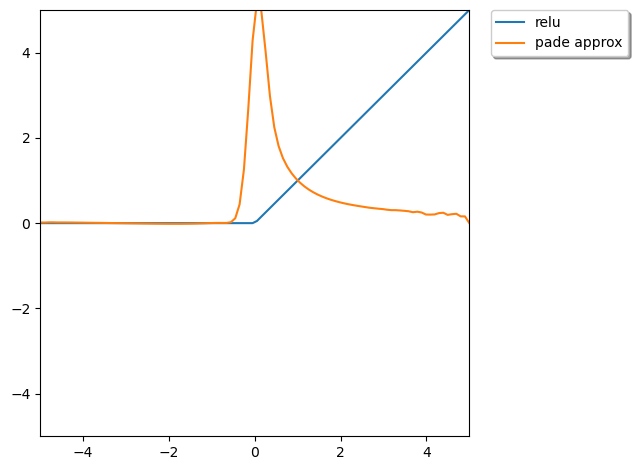

In [4]:
def relu(X):
   return numpy.maximum(0,X)

import logging

import numpy

import cicada
from cicada.additive import AdditiveProtocolSuite
from cicada.communicator import SocketCommunicator

from statistics import mean, stdev
from tqdm import *

import matplotlib.pyplot as plt



func2try = relu
def main(communicator):
    log = cicada.Logger(logging.getLogger(), communicator)
    protocol = AdditiveProtocolSuite(communicator)

    err_list = []
    
    axis = numpy.linspace(-5, 5, num=100)
    plt.plot(axis, func2try(axis), label="relu")
    
    logging.basicConfig(level=logging.INFO)
    pade_evals=[]
    for x in axis:
        pade_evals.append(protocol.reveal(protocol.pade_approx(func2try, protocol.share(src=0, secret=numpy.array(x), shape=()), scale=3, degree=14)))
        legit = func2try(x)
        err_list.append(legit-pade_evals[-1])
        #if communicator.rank ==1:
        #    print(legit_tanh, cic_pade_tanh, legit_tanh-cic_pade_tanh)
    

    
    if communicator.rank ==1:
        print(f"mean error: {mean(err_list)}, error stdev: {stdev(err_list)}")
                    
    plt.plot(axis, pade_evals, label='pade approx' )
                               
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0.0, shadow=True)
    plt.tight_layout()
    plt.axis([-5, 5, -5, 5])
    if communicator.rank == 1:
        plt.show()


SocketCommunicator.run(world_size=3, fn=main);